## **Twitter Emotion Recognition using RNN**

---

[Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## 1. Installing Hugging Face's nlp package

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 28.1 MB/s            
     |████████████████████████████████| 95 kB 7.3 MB/s             
     |████████████████████████████████| 212 kB 21.8 MB/s            
     |████████████████████████████████| 29.4 MB 270 kB/s             
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


## 2. Importing the libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 3. Importing the Dataset

In [4]:
dataset = nlp.load_dataset('emotion')

Dataset emotion downloaded and prepared to /home/datalore/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


Using custom data configuration default


In [12]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [104]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']
train = [el for el in list(train) if (el['label'] in ["sadness","anger","fear","joy"])]
val = [el for el in list(val) if (el['label'] in ["sadness","anger","fear","joy"])]
test = [el for el in list(test) if (el['label'] in ["sadness","anger","fear","joy"])]

In [15]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [105]:
tweets, labels = get_tweets(train)

In [106]:
a = tweets[3]
b = labels[3]
a,b

('i am feeling grouchy', 'anger')

## 4. Tokenizing the Tweets

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [107]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 310, 446, 2, 95, 31, 3799]]


## 5. Padding and Truncating Sequences

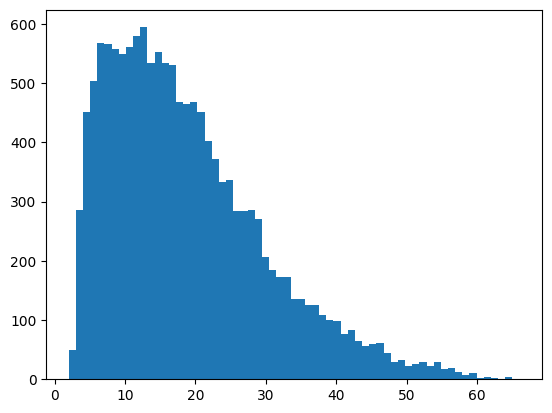

In [108]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [109]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [110]:
padded_train_sequences[10]

## 6. Preparing the Labels

In [111]:
classes = set(labels)
print(classes)

{'anger', 'joy', 'sadness', 'fear'}


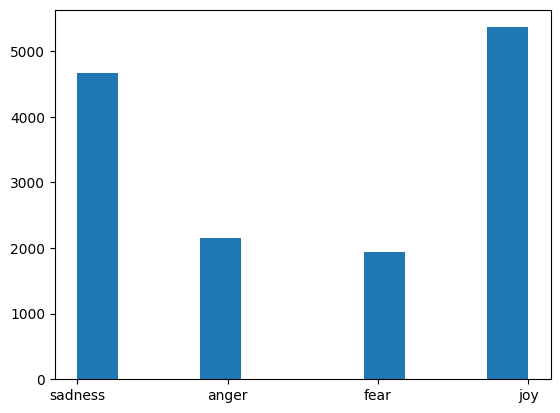

In [112]:
plt.hist(labels, bins=11)
plt.show()

In [113]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [114]:
classes_to_index

{'anger': 0, 'joy': 1, 'sadness': 2, 'fear': 3}

In [115]:
index_to_classes

{0: 'anger', 1: 'joy', 2: 'sadness', 3: 'fear'}

In [116]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [117]:
train_labels = names_to_ids(labels)
print(train_labels[10])

2


## 7. Creating the Model

In [118]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8. Training the Model

In [119]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [120]:
val_tweets[20], val_labels[20]

('i feel that it is something that will never really be resolved', 1)

In [121]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
442/442 [==============================] - 26s 45ms/step - loss: 1.1881 - accuracy: 0.4598 - val_loss: 0.7457 - val_accuracy: 0.7076
Epoch 2/15
442/442 [==============================] - 18s 40ms/step - loss: 0.4602 - accuracy: 0.8006 - val_loss: 0.4146 - val_accuracy: 0.8179
Epoch 3/15
442/442 [==============================] - 18s 40ms/step - loss: 0.2541 - accuracy: 0.9038 - val_loss: 0.3187 - val_accuracy: 0.9024
Epoch 4/15
442/442 [==============================] - 18s 40ms/step - loss: 0.1437 - accuracy: 0.9559 - val_loss: 0.2699 - val_accuracy: 0.9184
Epoch 5/15
442/442 [==============================] - 18s 40ms/step - loss: 0.0960 - accuracy: 0.9719 - val_loss: 0.2763 - val_accuracy: 0.9173
Epoch 6/15
442/442 [==============================] - 18s 40ms/step - loss: 0.0742 - accuracy: 0.9787 - val_loss: 0.2937 - val_accuracy: 0.9207
Epoch 7/15
442/442 [==============================] - 18s 40ms/step - loss: 0.0574 - accuracy: 0.9837 - val_loss: 0.3123 - val_accuracy:

## 9. Evaluating the Model

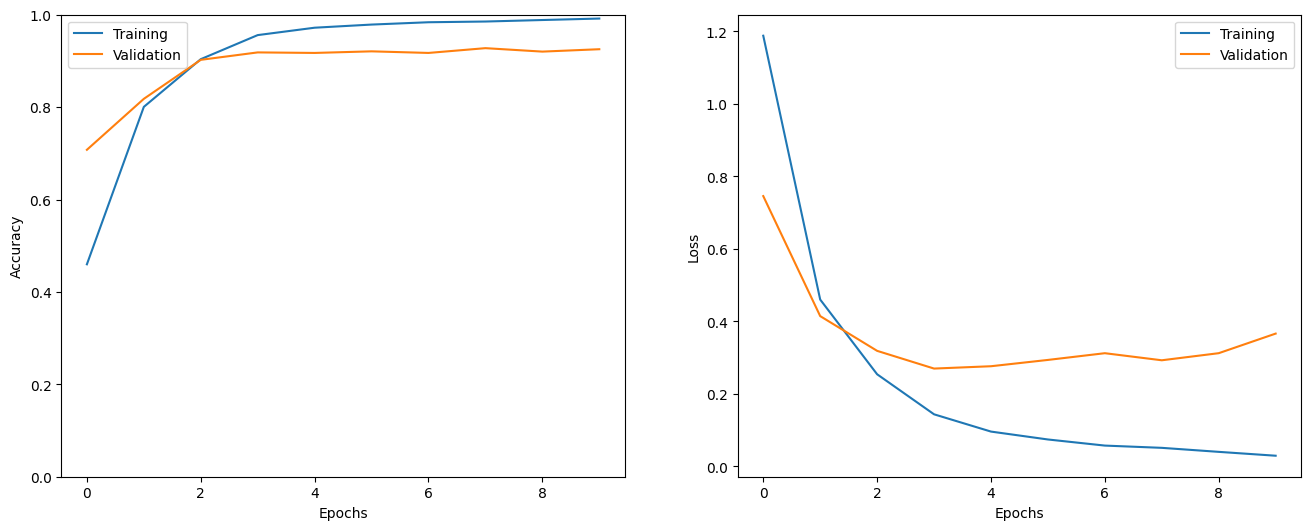

In [122]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [123]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [124]:
eval = model.evaluate(test_sequences, test_labels)

56/56 [==============================] - 0s 8ms/step - loss: 0.3629 - accuracy: 0.9155


In [125]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  # print('Predicted Emotion:',p, '\n')
  classes_x=np.argmax(p,axis=0)
  print('Predicted Emotion:', index_to_classes.get(classes_x), '\n')

Tweet: i feel ecstatic and privileged
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i feel more so lately than ever that life is so precious
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i reread for comfort the familiarity of a book whose plot i already know is easier to deal with when im feeling stressed than a new to me book with all its unknowns
Actual Emotion: sadness
Predicted Emotion: sadness 

Tweet: i feel even more determined to keep up our once per week tradition that my son started
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i feel the need to pimp this since raini my beloved rocky casting director loves it so much
Actual Emotion: joy
Predicted Emotion: joy 



In [127]:
preds = model.predict(test_sequences).argmax(1)
preds.shape, test_labels.shape

((1775,), (1775,))

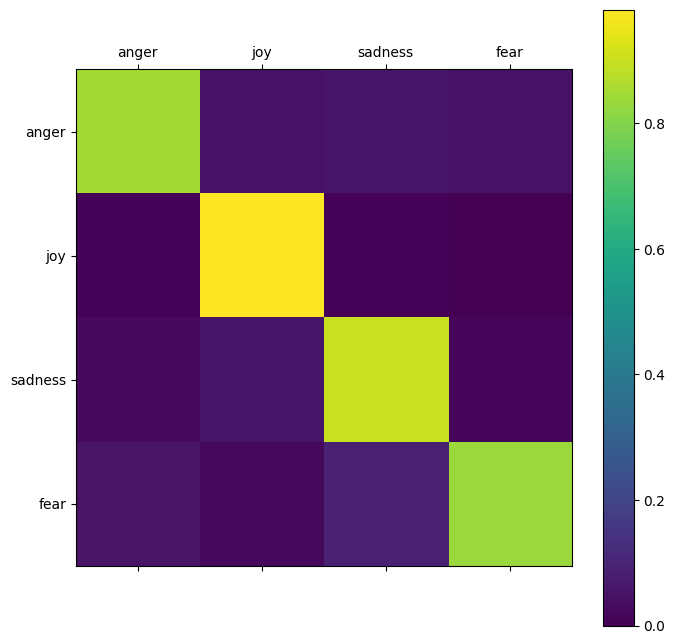

In [129]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 4)), labels=classes)
    plt.yticks(list(range(0, 4)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(test_labels, preds, list(classes))

In [131]:
text = " i was walking down the street and i met an old friend, i was chocked when i saw him"
sequence = get_sequences(tokenizer,[text])
sequence_expanded = np.expand_dims(sequence[0], axis=0)
index_to_classes.get(model.predict(sequence_expanded).argmax())

'anger'